In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import linear_model
from mpl_toolkits import mplot3d


In [2]:
def plot_one(ax, to_plot, color, ecolor, fill_color, label, fmt="x--", fill_between=True, metric='time_per_run', bench_x="bench_x"):
    y_col = metric + '_mean'
    lo_err_col = metric + '_abs_lo_diff'
    hi_err_col = metric + '_abs_hi_diff'
    x = to_plot[bench_x]
    y = to_plot[y_col]
    lo_err = to_plot[lo_err_col]
    hi_err = to_plot[hi_err_col]
    error = [-lo_err, hi_err]
    if fill_between:
        ax.fill_between(x, y + lo_err, y + hi_err, color=fill_color)
    ax.errorbar(x, y, yerr=error, fmt=fmt, color=color, ecolor=ecolor, label=label)

def plot_info_for_axs(df, title, axs, linreg = True, log_scale=False, has_compile=True, bench_x="bench_x"):
    # Setup
    # Assumes existence of bench_x column
    # fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    staged = df[df['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']]
    run = df[df['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']]

    # Initial analysis
    plot_one(axs[0], staged, "blue", "black", "#e3e1de", "Compiled", bench_x=bench_x)
    plot_one(axs[0], run, "orange", "black", "#e3e1de", "Interpreted", bench_x=bench_x)
    axs[0].legend()
    axs[0].set_xlabel("Dynamic Input x")
    axs[0].set_ylabel("Runtime (ns)")
    if log_scale:
        axs[0].set_yscale('log', nonposy='clip')
    # plt.plot(x, y, 'x--', color='blue', label="time/run for staged fib")
    axs[0].set_title(f"{title}: Time/run")

    # Ratio

    joined = staged.join(run.set_index(bench_x), on=bench_x, lsuffix="_staged", rsuffix="_run")
    joined = joined[joined['benchmark_name_staged'].str[:-6] == joined['benchmark_name_run'].str[:-3]]

    axs[1].plot(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged'], "x--")
    for i,j in zip(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged']):
        axs[1].annotate(str(round(j, 2)),xy=(i,j))

    axs[1].set_xlabel(bench_x)
    axs[1].set_ylabel("Runtime ratio")
    axs[1].set_title(f"{title}: Ratio of speedup: $t(p, x)/t_p(x)$")

    # Compile + run VS just run
    if has_compile:
        peval = df[df['benchmark_name'].str.endswith('compile')][[bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']].iloc[0]
        new_staged = (peval + staged).append(peval)
        new_run = run # pd.concat([run, pd.DataFrame([[0, 0, 0, 0]], columns=[bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff'])]) 

        if linreg:
            plot_one(axs[2], new_staged, "blue", "black", "#e3e1de", "Combined run time of the staged version", fmt='.', fill_between=False, bench_x=bench_x)
            plot_one(axs[2], new_run, "orange", "black", "#e3e1de", "Combined run time of the non staged version", fmt='.', fill_between=False, bench_x=bench_x)

            model_staged = linear_model.LinearRegression()
            model_staged.fit(np.array(new_staged[bench_x]).reshape(-1, 1), new_staged['time_per_run_mean'])
            model_run = linear_model.LinearRegression()
            model_run.fit(np.array(new_run[bench_x]).reshape(-1, 1), new_run['time_per_run_mean'])

            X = np.linspace(0, 100).reshape(-1, 1)
            y_staged = model_staged.predict(X)
            y_run = model_run.predict(X)
            axs[2].plot(X, y_staged, "-", color="cyan", label="Linear model for the combined run time of the staged version")
            axs[2].plot(X, y_run, "-", color="#f7b713", label="Linear model for the run time of the non staged version")

            x_intersection = (model_run.intercept_-model_staged.intercept_) / (model_staged.coef_[0] - model_run.coef_[0])
            y_intersection = model_staged.predict([[x_intersection]])[0]
            axs[2].plot(x_intersection, y_intersection, "o", color="red", label="intersection")
            axs[2].annotate(str((round(x_intersection, 2), round(y_intersection, 2))), xy=(x_intersection, y_intersection))
        else:
            plot_one(axs[2], new_staged, "blue", "black", "#e3e1de", "Combined run time of the staged version", fmt='.--', fill_between=False, bench_x=bench_x)
            plot_one(axs[2], new_run, "orange", "black", "#e3e1de", "Combined run time of the non staged version", fmt='.--', fill_between=False, bench_x=bench_x)
        axs[2].legend()
        axs[2].set_xlabel(bench_x)
        axs[2].set_ylabel("Runtime (ns)")
        axs[2].set_title(f"{title}: Time/run: Interpreted VS Compilation + Eval")

    # plt.show()

def plot_info_for(df, title, linreg=True, log_scale=False, has_compile=True, bench_x = 'bench_x'):
    fig, axs = plt.subplots(3, 1, figsize=(15, 20))
    plot_info_for_axs(df, title, axs, linreg, log_scale=log_scale, has_compile=has_compile, bench_x=bench_x)
    plt.show()


In [3]:
df = pd.read_csv('../traces/benchmarks/2023_3_9_regexp_1_1000.csv')

In [4]:
df_accept = df[df['benchmark_name'].str.startswith('regexp_0(a*b)*_accept_')]

In [5]:
df_accept['bench_d'] = [100, 80, 60, 40, 20] + [0] + [100, 80, 60, 40, 20]

/home/milkfans/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_accept

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mGC_per_run_abs_hi_diff,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff,bench_d
11,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaaaaaa...,0.846003,5.360683e+06,-4.114942e+05,4.780184e+05,1.0,1540718.0,-1.862645e-09,3.259629e-09,0.999932,...,0.001925,0.989135,0.272039,-0.004354,0.003499,NaN,0.0,0.0,0.0,100
12,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaaaaaa...,0.542179,5.176586e+06,-4.837583e+05,5.938415e+05,1.0,1248341.0,-1.629815e-09,2.561137e-09,0.999937,...,0.003958,0.983605,0.213811,-0.004546,0.003603,NaN,0.0,0.0,0.0,80
13,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaabaaa...,0.762908,4.126013e+06,-5.960200e+05,5.566978e+05,1.0,981896.0,-1.629815e-09,1.746230e-09,0.999931,...,0.004055,0.974894,0.153410,-0.003767,0.003607,NaN,0.0,0.0,0.0,60
14,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaabaaa...,0.886139,2.539098e+06,-1.716587e+05,1.911361e+05,1.0,654074.0,-6.984919e-10,1.396984e-09,0.999433,...,0.004805,0.913273,0.088700,-0.004809,0.003874,NaN,0.0,0.0,0.0,40
15,regexp_0(a*b)*_accept_0_0aaaaaaababaaaabaabb_s...,0.714955,1.828856e+06,-1.315985e+05,1.604773e+05,1.0,353287.0,-4.656613e-10,6.984919e-10,0.998815,...,0.004141,0.694172,0.028707,-0.004218,0.004035,NaN,0.0,0.0,0.0,20
16,regexp_0(a*b)*_accept_0_compile,0.833845,4.959762e+05,-5.286753e+04,5.266113e+04,1.0,110268.0,-1.746230e-10,2.037268e-10,0.993050,...,0.003558,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0
17,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaaaaaa...,0.945220,5.495213e+08,-2.418362e+07,2.402107e+07,1.0,60552418.0,-8.195639e-08,1.192093e-07,1.000000,...,0.010921,0.998075,3.272684,-0.018397,0.023592,NaN,0.0,0.0,0.0,100
18,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaaaaaa...,0.918012,4.273938e+08,-2.549887e+07,2.260096e+07,1.0,48146469.0,-5.215406e-08,1.117587e-07,1.000000,...,0.015011,0.995950,3.079131,-0.027334,0.033580,NaN,0.0,0.0,0.0,80
19,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaabaaa...,0.877964,2.838344e+08,-1.686726e+07,1.839082e+07,1.0,35377197.0,-5.215406e-08,6.705523e-08,1.000000,...,0.009638,0.996387,2.878860,-0.015231,0.019823,NaN,0.0,0.0,0.0,60
20,regexp_0(a*b)*_accept_0_0aaaaaaaaaaaaaaaaabaaa...,0.854924,2.225728e+08,-1.674255e+07,1.773809e+07,1.0,23518070.0,-3.725290e-08,4.097819e-08,1.000000,...,0.014393,0.994366,2.461283,-0.022381,0.032141,NaN,0.0,0.0,0.0,40


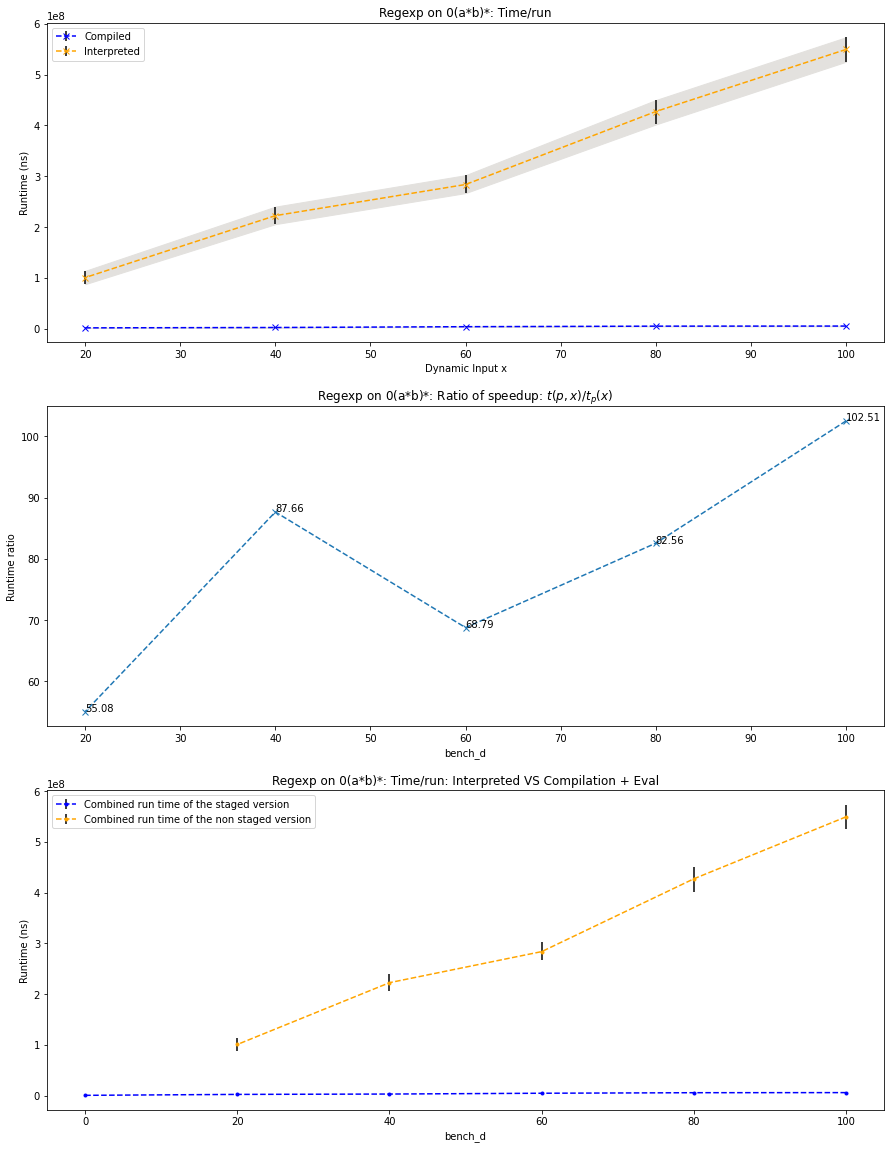

In [7]:
plot_info_for(df_accept, "Regexp on 0(a*b)*", linreg=False, log_scale=False, has_compile=True, bench_x = 'bench_d')

In [13]:
df2 = pd.read_csv('../traces/benchmarks/2023_3_9_regexp_2_1000.csv')
df2_accept = df2[df2['benchmark_name'].str.match('regexp_.*_accept_')]

In [16]:
df2_accept

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mGC_per_run_abs_lo_diff,mGC_per_run_abs_hi_diff,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff
11,regexp_1**_accept_0_11111111111111111111111111...,0.780142,1.254132e+07,-1.573852e+06,1.365765e+06,1.0,2817689.0,-3.725290e-09,6.053597e-09,0.999971,...,-0.007989,0.006414,0.996367,0.498303,-0.005269,0.004029,NaN,0.0,0.0,0.0
12,regexp_1**_accept_0_11111111111111111111111111...,0.882896,9.176250e+06,-6.849228e+05,6.608461e+05,1.0,2256856.0,-3.259629e-09,4.190952e-09,0.999989,...,-0.004578,0.004016,0.996476,0.423719,-0.003488,0.003465,NaN,0.0,0.0,0.0
13,regexp_1**_accept_0_11111111111111111111111111...,0.610270,4.918501e+06,-9.247650e+05,8.785076e+05,1.0,1696410.0,-2.328306e-09,3.492460e-09,0.999958,...,-0.004568,0.003668,0.992628,0.307092,-0.003933,0.003479,NaN,0.0,0.0,0.0
14,regexp_1**_accept_0_11111111111111111111111111...,0.923140,4.763315e+06,-2.213177e+05,2.338728e+05,1.0,1136667.0,-1.629815e-09,2.095476e-09,0.999935,...,-0.004444,0.003890,0.986151,0.209128,-0.003320,0.003311,NaN,0.0,0.0,0.0
15,regexp_1**_accept_0_11111111111111111111_staged,0.861176,2.556149e+06,-2.377940e+05,2.315086e+05,1.0,577897.0,-6.984919e-10,1.164153e-09,0.999704,...,-0.005158,0.004176,0.920586,0.084153,-0.004654,0.003677,NaN,0.0,0.0,0.0
16,regexp_1**_accept_0_compile,0.644485,2.165854e+05,-3.061661e+04,3.795833e+04,1.0,43187.0,-6.548362e-11,8.003553e-11,0.871732,...,-0.004621,0.003766,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0
17,regexp_1**_accept_0_11111111111111111111111111...,0.901869,1.629371e+08,-1.023791e+07,9.509613e+06,1.0,24603156.0,-2.980232e-08,5.215406e-08,1.000000,...,-0.005849,0.006480,0.998542,2.437937,-0.013833,0.017318,NaN,0.0,0.0,0.0
18,regexp_1**_accept_0_11111111111111111111111111...,0.869875,1.424719e+08,-1.254347e+07,9.915944e+06,1.0,19691191.0,-2.980232e-08,3.725290e-08,1.000000,...,-0.008764,0.007137,0.998824,2.272548,-0.013736,0.010670,NaN,0.0,0.0,0.0
19,regexp_1**_accept_0_11111111111111111111111111...,0.868346,9.673934e+07,-7.517520e+06,7.461584e+06,1.0,14779445.0,-2.421439e-08,2.607703e-08,1.000000,...,-0.006264,0.005368,0.999154,2.128402,-0.008854,0.009205,NaN,0.0,0.0,0.0
20,regexp_1**_accept_0_11111111111111111111111111...,0.860496,4.878852e+07,-3.764734e+06,3.186647e+06,1.0,9868082.0,-1.303852e-08,2.048910e-08,0.999999,...,-0.004842,0.004785,0.999275,1.898575,-0.006214,0.006939,NaN,0.0,0.0,0.0


In [17]:
df2_accept['bench_d'] = [100, 80, 60, 40, 20] + [0] + [100, 80, 60, 40, 20]

/home/milkfans/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


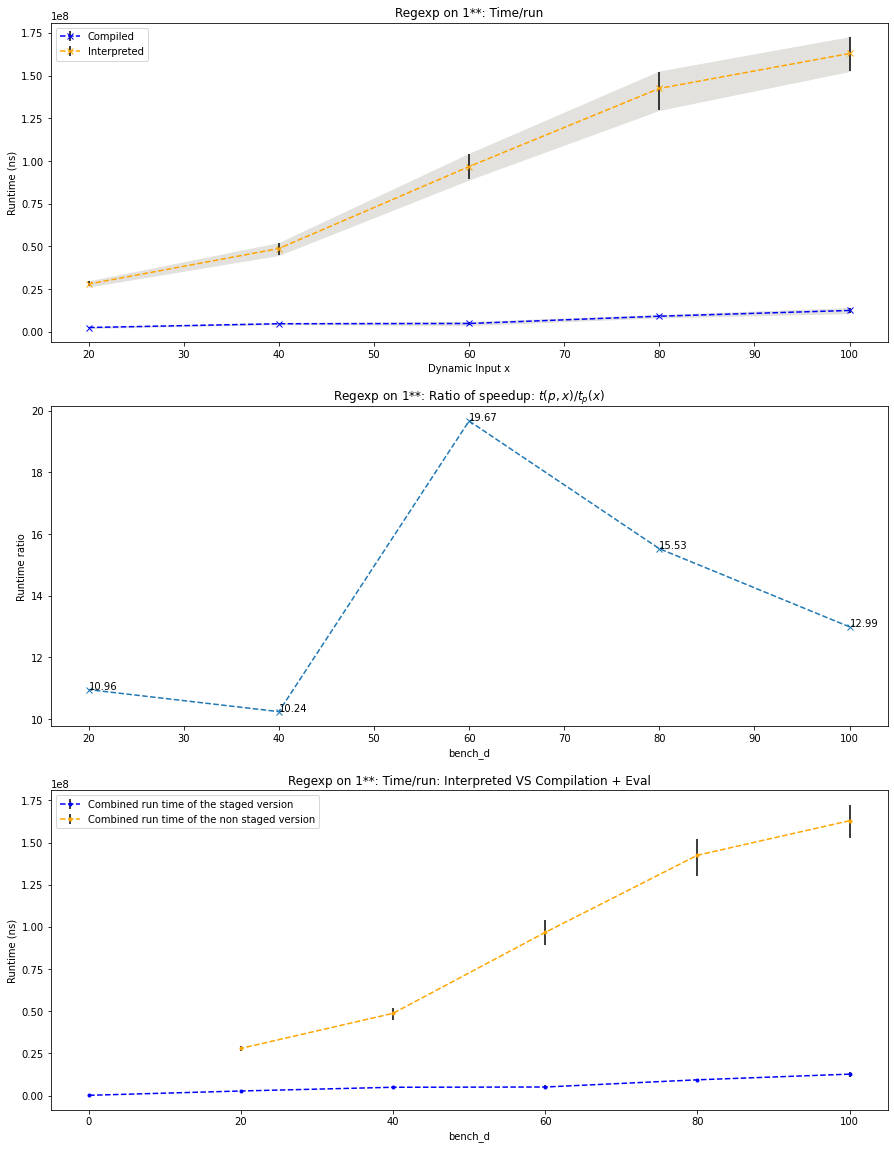

In [19]:
plot_info_for(df2_accept, "Regexp on 1**", linreg=False, log_scale=False, has_compile=True, bench_x = 'bench_d')

In [23]:
df2_reject = df2[df2['benchmark_name'].str.match('regexp_.*_reject_')]
df2_reject['bench_d'] = [100, 80, 60, 40, 20] + [0] + [100, 80, 60, 40, 20]

/home/milkfans/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


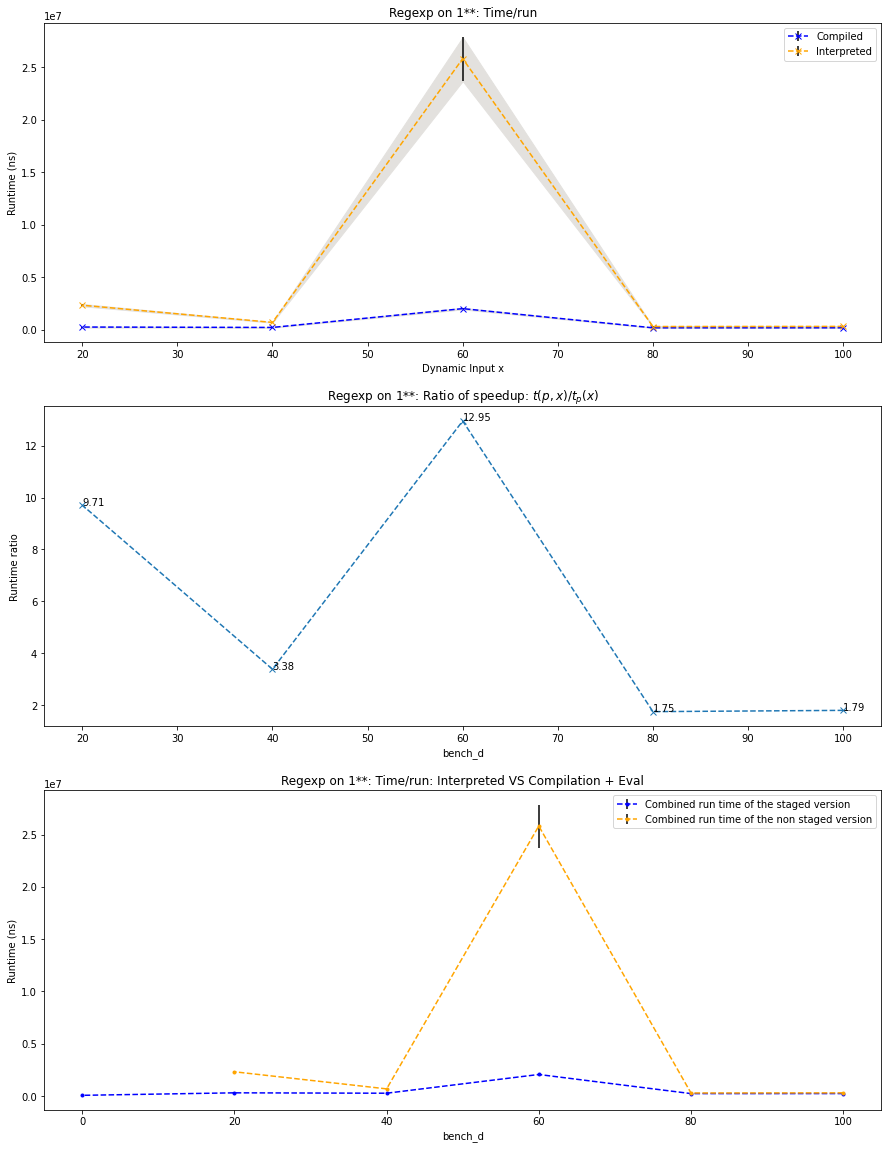

In [24]:
plot_info_for(df2_reject, "Regexp on 1**", linreg=False, log_scale=False, has_compile=True, bench_x = 'bench_d')